### 1. Prepare/Load Data
### 2. Build Model
### 3. Fitting model
### 4. Making predictions / evaluating model
### 5. Saving and loading the model


In [34]:
import torch
from torch import nn  # contains neural network building blocks for PyTorch
import matplotlib.pyplot as plt



In [3]:
# 1. Data Preparing and loading 
# Starting with a linear regression formula

# create known parameters
weight = 0.7
bias = 0.3 

start = 0
end = 1 

step =0.02

X = torch.arange(start,end,step).unsqueeze(dim =1)
y = weight*X +bias

X[:10], y[:10], len(X), len(y)



(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]),
 50,
 50)

In [3]:
len(X),len(y)

(50, 50)

In [ ]:
# Test, Validation, Train split 
# 80% train , 20% test
train_split = int(0.8*len(X))
train_split
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)


(40, 40, 10, 10)

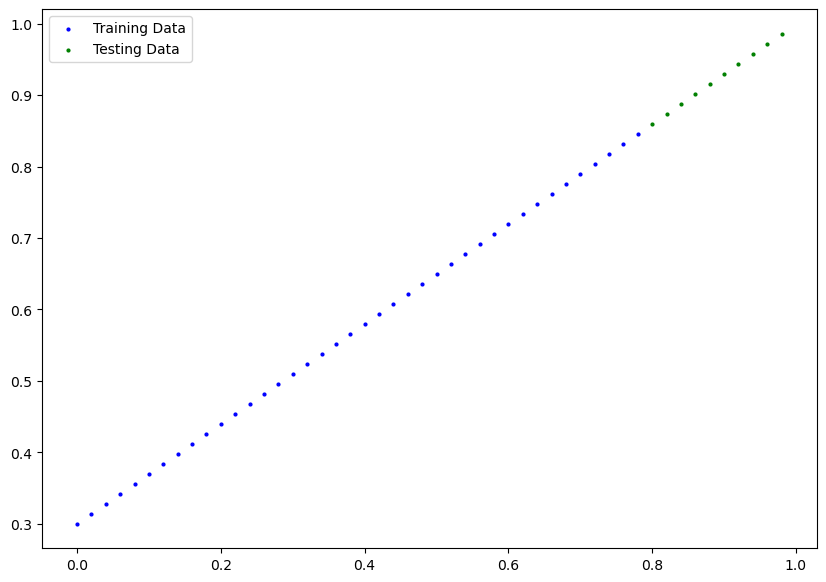

In [10]:
def plot_pred(train_data = X_train,
              train_labels=y_train,
              test_data=X_test,
              test_labels=y_test,
              predictions=None):
    plt.figure(figsize=(10,7))
    plt.scatter(train_data, train_labels, c='b', s=4, label= 'Training Data')

    plt.scatter(test_data, test_labels, c='g', s=4, label = 'Testing Data')
    if predictions is not None:
        plt.scatter(test_data, predictions, c = 'r', s =4, label='Predictions')
    plt.legend()
plot_pred()

In [114]:
# 2. Build a Model .40

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1,
                                    requires_grad=True,
                                    dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1,
                                    requires_grad=True,
                                    dtype=torch.float))
    def forward(self, x: torch.Tensor):
            return self.weights*x + self.bias
        


### PyTorch essentials
* torch.nn = contains everything fot computational graphs (neural networks)
* torch.nn.Parameter = what parameters should the model learn 
* torch.nn.Module = The best class for all nn module, if subclassing, overwrite forward
* def forward() - all nn.module subclasses require you to overwrite forward, this method defines what happenes in the forward method






In [115]:
# Checking contents of model

# create random seed
torch.manual_seed(42)
#create an instance of the model (subclass of nn.module)
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [116]:
#model output of weight and bias 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [117]:
# true values / target values 
weight, bias

(0.7, 0.3)

In [118]:
# making predicts using torch.inference
# predictive power = how well it predicts y_test based on X_test
with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

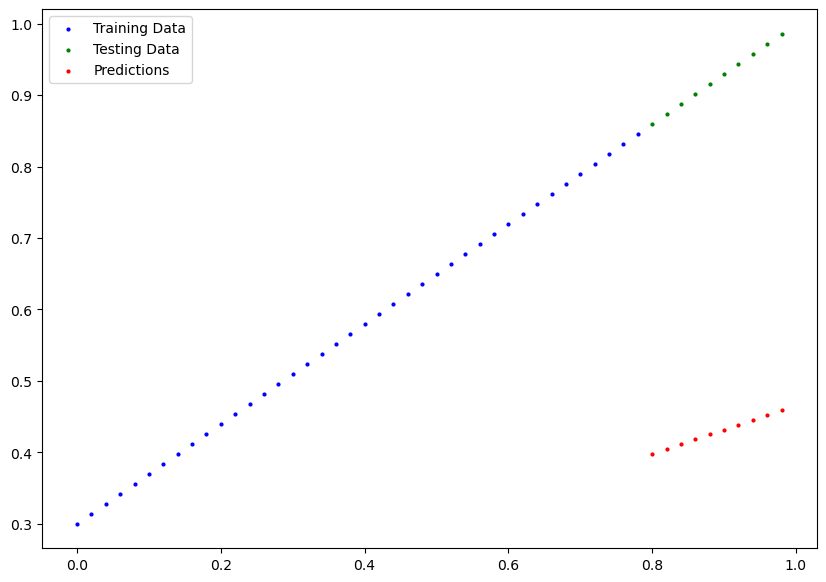

In [119]:
plot_pred(predictions=y_preds) # initially the preds are very bad, very far away

### Creating a Loss Function and Optimizer in PyTorch

To measure how poor the predictions are, we can use a **loss function**.

For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a **loss function** as well as an **optimizer**.

The roles of these are:  

| Function | What does it do? | Where does it live in PyTorch? | Common values |
|-----------|------------------|--------------------------------|----------------|
| **Loss function** | Measures how wrong your model's predictions (e.g. `y_preds`) are compared to the true labels (e.g. `y_test`). Lower is better. | PyTorch has plenty of built-in loss functions in [`torch.nn`](https://pytorch.org/docs/stable/nn.html#loss-functions). | Mean Absolute Error (MAE) for regression problems — [`torch.nn.L1Loss()`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html).<br>Binary Cross Entropy for binary classification — [`torch.nn.BCELoss()`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html). |
| **Optimizer** | Tells your model how to update its internal parameters to best lower the loss. | You can find various optimization function implementations in [`torch.optim`](https://pytorch.org/docs/stable/optim.html). | Stochastic Gradient Descent — [`torch.optim.SGD()`](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD).<br>Adam optimizer — [`torch.optim.Adam()`](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam). |



In [120]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [121]:
# set up a loss function
loss_fn = nn.L1Loss()


#set up optimiser - params are the parameters you want to optimise
optimiser = torch.optim.SGD(params = model_0.parameters(),
                            lr=0.01)    #lr = learning rate , you choose (default = 0.1), defines how much the model changes the params in each step


### Training loop (testing loop)

0. Loop through data
1. Forward pass (data moving through forward() func)
2. alculate the loss ( compare forward pass preditictions to actual vals)
3. Optimiser zero grad 
4. Loss backwards - moves backwards through the network to calculate gradient of each aparamer wrt the loss
5. Optimiser step - Use the optimiser to adjust our models parameters to try and improve the loss (gradient decent)


In [ ]:
torch.manual_seed(42)
# An epoch is one loop through the data...
epochs = 100
# track vals 
epoch_count =[]
loss_vals = []
test_loss_vals = []

# 0. Loop through data
for epoch in range(epochs):
    # set the model to training mode
    model_0.train() # train mode in PyTorch sets all params that require gradients to require gradients
    # Forward pass
    y_pred = model_0(X_train)
    # Calculate the loss
    loss = loss_fn(y_pred, y_train) # difference between predictions and actual
     # print(loss)
    # Optimiser 0 grad
    optimiser.zero_grad()
    #Perform back prop on loss wrt params
    loss.backward()
    #step the optimiser 
    optimiser.step()
    # Testing
    model_0.eval()
    with torch.inference_mode(): # turns off gradient tracking 
        # 1. forward pass
        test_pred = model_0(X_test)
        test_loss = loss_fn(test_pred, y_test)
    epoch_count.append(epoch)
    loss_vals.append(loss)
    test_loss_vals.append(test_loss)
print(epoch_count[-1], loss_vals[-1], test_loss_vals[-1] )
print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

99 tensor(0.0248, grad_fn=<MeanBackward0>) tensor(0.0569)
Epoch: 99 | Loss: 0.02479521557688713 | Test loss: 0.05687814950942993


In [123]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

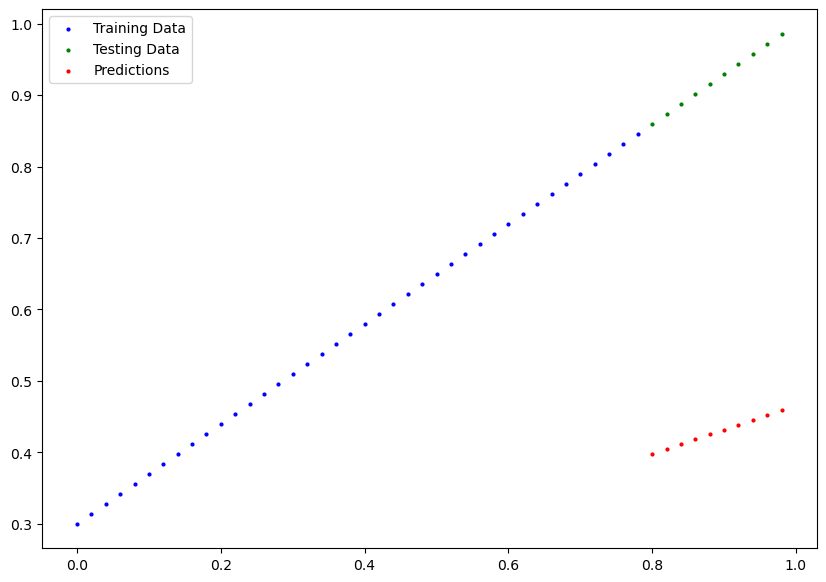

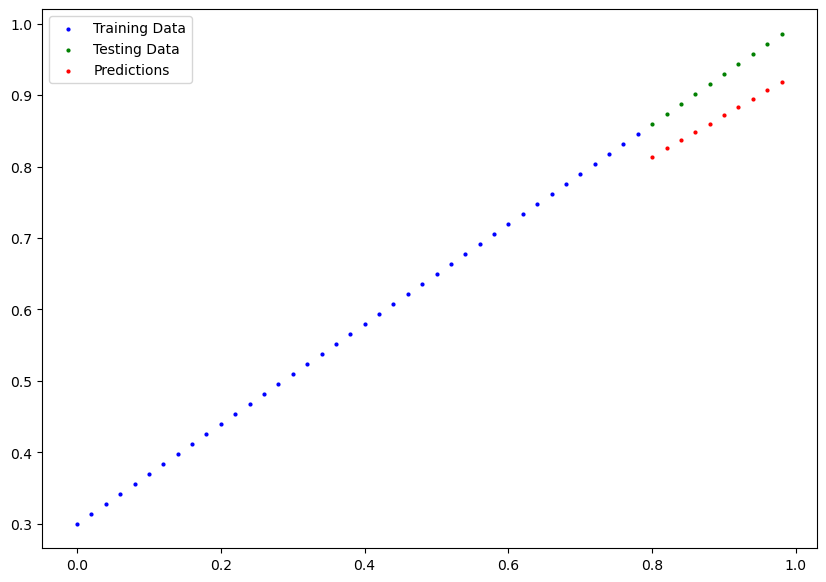

In [124]:
# now we can see the model get better 
with torch.inference_mode():
    y_preds_new = model_0(X_test)

plot_pred(predictions=y_preds)
plot_pred(predictions=y_preds_new)

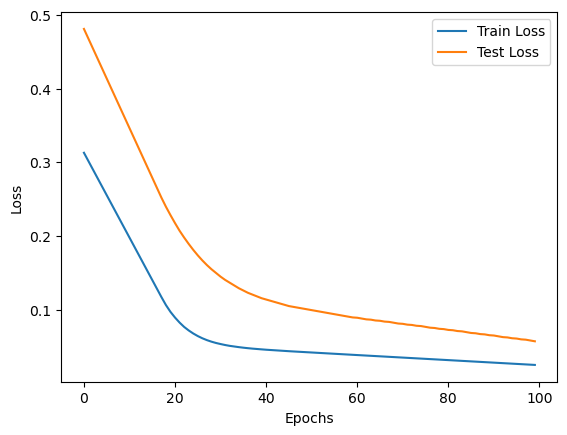

In [ ]:
# convert from tensor to numpy to plot =  np.array(torch.tensor(loss_vals).numpy())
import numpy as np

plt.plot(epoch_count, np.array(torch.tensor(loss_vals).numpy()), label = 'Train Loss')
plt.plot(epoch_count, np.array(torch.tensor(test_loss_vals).numpy()), label= 'Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

## Saving a model in PyTorch

Three methods to save and load 

1. 'torch.save()' - allows you to save PyTorch object in Python's pickle format
2. 'torch.load()' - allows you to load 
3. 'torch.nn.Module.load_state_dict()' allows to load a models saved dict 



In [128]:
# Saving 
from pathlib import Path
#1. create model directory
MODEL_PATH = Path('C:/Users/willf/JUNO-Deep-Learning-Project/models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME


print(f'Saving model to: {MODEL_SAVE_PATH}')
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)



Saving model to: C:\Users\willf\JUNO-Deep-Learning-Project\models\model_0.pth


# Loading model

I saved the state_dict not the full model, so I will create a new instance of the model class.




In [129]:
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


C:\Users\willf\AppData\Local\Temp\ipykernel_6956\3916095717.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [ ]:
# Now they match 
loaded_model_0.state_dict(), model_0.state_dict()

(OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))]),
 OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))]))

In [132]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

In [135]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Neural Network Classification Model 

In [4]:
import sklearn
from sklearn.datasets import make_circles

#make 1000 samples 
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)
len(X), len(y)

(1000, 1000)

In [5]:
print(f'First 5 samples of X:\n {X[:5]}')
print(f'First 5 samples of X:\n {y[:5]}')

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of X:
 [1 1 1 1 0]


In [6]:
# y = 0 or 1 , so binary classifcation 
import pandas as pd
circles = pd.DataFrame({'X1' : X[:,0],
                        'X2': X[:,1],
                        'label':y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


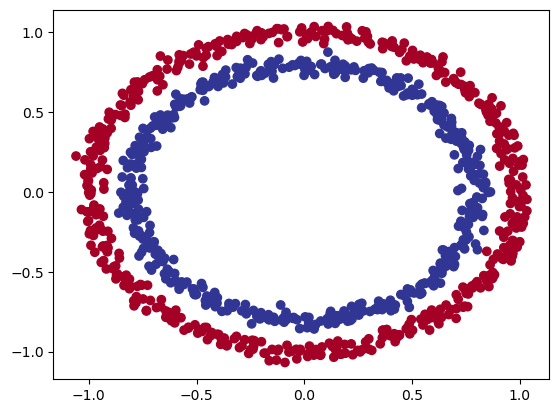

In [7]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

In [8]:
# Check input and output shapes 
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
# We need it in tensors 
X_sample = X[0]
y_sample = y[0]
import torch
torch.__version__

type(X)



numpy.ndarray

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
# split test/train 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [12]:
# Model
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# subclass nn.Module


In [13]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        #2 nn.Linear layers
        self.layer_1 = nn.Linear(in_features=2, out_features=5)# takes in 2 , outs 5, so the next layer has to input 5
        self.layer_2 = nn.Linear(in_features=5, out_features=1)  # takes in 5 from the layer above, outputs 1 as its the final layer 
    # define a forward method that outlines forward pass
    def forward(self,x):
        return self.layer_2(self.layer_1(x)) # x to layer 1 then to layer 2 then out 
    
model_1 = CircleModelV0().to(device)
model_1

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
# Replicate the model above using nn. Sequential()
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)
model_1



Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
# Make Predictions
model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0551, -0.0818],
                      [ 0.2663,  0.4360],
                      [-0.2881,  0.1672],
                      [ 0.2402, -0.3981],
                      [-0.3248, -0.5397]])),
             ('0.bias', tensor([ 0.2349,  0.6010,  0.6478, -0.2467,  0.2442])),
             ('1.weight',
              tensor([[ 0.3554, -0.4130,  0.3318,  0.0903, -0.3409]])),
             ('1.bias', tensor([0.2757]))])

In [16]:
with torch.inference_mode():
    untrained_preds = model_1(X_test.to(device))
print(f'{len(untrained_preds)} and shape: {untrained_preds.shape}')


200 and shape: torch.Size([200, 1])


In [17]:
# loss func and optimiser
# using torch.nn.BECWithLogitsLoss() for Binary Cross Entropy
torch.manual_seed(42)
epochs = 1000
# track vals 
epoch_count =[]
loss_vals = []
test_loss_vals = []

loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.SGD(params=model_1.parameters(),lr = 0.1)

def accuracy_fn(y_true,y_pred):
    correct = torch.eq(y_true,y_pred).sum().item() # torch eq checks if arg 1 and 2 are eq-ual
    acc = (correct/len(y_pred))*100   # percentage correct 
    return acc # return percentage





### Train Loop

1. Forward Pass
2. Calculate loss
3. Optimiser zero grad
4. Loss backwards
5. Optimiser step (grad descent)

Raw logits -> prediction probabilities - > prediction labels


In [18]:
with torch.inference_mode():

    y_logits = model_1(X_test.to(device))[:5]
y_logits

tensor([[0.2366],
        [0.2141],
        [0.2597],
        [0.2302],
        [0.2029]])

In [19]:
y_test[:5] # different formats

tensor([1., 0., 1., 0., 1.])

In [20]:
# Fing pred labels
y_pred_probs = torch.sigmoid(y_logits)
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

In [21]:
y_pred1 = torch.round(y_pred_probs)
y_pred_lab = torch.round(torch.sigmoid( model_1(X_test.to(device))[:5]))
print(torch.eq(y_pred1.squeeze(), y_pred_lab.squeeze()))
y_pred1.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

In [22]:
# logits are the raw output of a classification model
# train test loop 
torch.manual_seed(42)
epochs = 100
# track vals 
epoch_count =[]
loss_vals = []
test_loss_vals = []

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    y_logits = model_1(X_train).squeeze()        # as done above
    y_pred1 = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train) # pass in logits as loss_fn = BCSWithLogitsLoss
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred1)

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        #print(test_logits.size(), X_test.size())
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred = test_pred)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Acc: {acc:.2f}%, Test loss: {test_loss:.5f}, Test_acc: {test_acc:.2f}%')


Epoch: 0, Acc: 50.00%, Test loss: 0.69791, Test_acc: 50.00%
Epoch: 10, Acc: 50.00%, Test loss: 0.69409, Test_acc: 50.00%
Epoch: 20, Acc: 50.00%, Test loss: 0.69314, Test_acc: 50.00%
Epoch: 30, Acc: 50.00%, Test loss: 0.69299, Test_acc: 50.00%
Epoch: 40, Acc: 51.62%, Test loss: 0.69307, Test_acc: 52.00%
Epoch: 50, Acc: 54.12%, Test loss: 0.69320, Test_acc: 52.50%
Epoch: 60, Acc: 52.00%, Test loss: 0.69335, Test_acc: 51.00%
Epoch: 70, Acc: 51.12%, Test loss: 0.69348, Test_acc: 50.00%
Epoch: 80, Acc: 51.12%, Test loss: 0.69361, Test_acc: 49.00%
Epoch: 90, Acc: 51.38%, Test loss: 0.69373, Test_acc: 46.50%


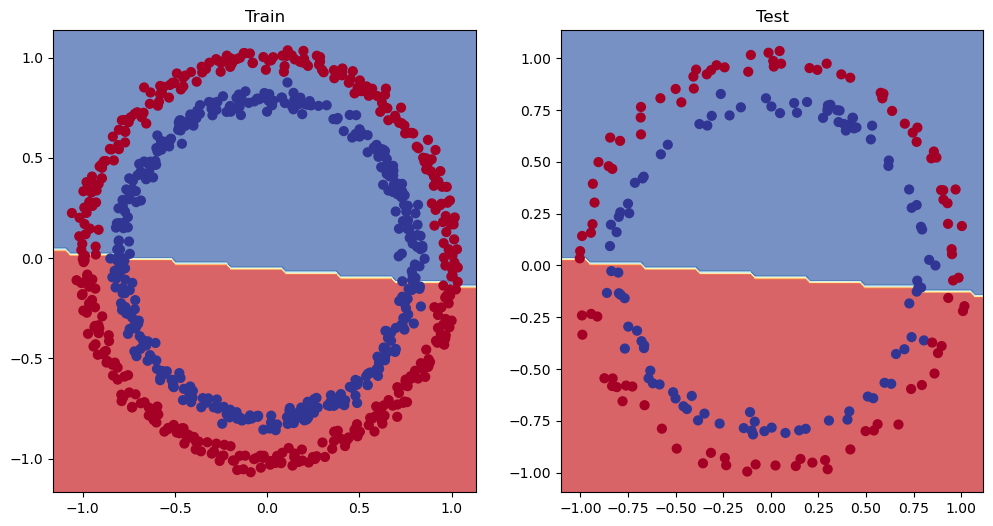

In [23]:
## model seems to be randomly guessing
## Make predictions and visualise

from helper_functions import plot_decision_boundary, plot_predictions
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1,X_test,y_test)





In [24]:
# Model is trying to split the circular data with 1 linear line , 
# from the linear layers in the model 
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self,x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
model_2 = CircleModelV1().to(device)
model_2

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
loss_fn = nn.BCEWithLogitsLoss()
optimiser = torch.optim.SGD(params=model_2.parameters(),lr = 0.1)

In [26]:
# train loop 
torch.manual_seed(42)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device) , y_test.to(device)

for epoch in range(epochs):
    model_2.train()
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    acc = accuracy_fn(y_true=y_train,y_pred=y_pred )

    loss = loss_fn(y_pred, y_train)
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        #print(test_logits.size(), X_test.size())
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred = test_pred)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Acc: {acc:.2f}%, Test loss: {test_loss:.5f}, Test_acc: {test_acc:.2f}%')


    






Epoch: 0, Acc: 50.88%, Test loss: 0.69261, Test_acc: 51.00%
Epoch: 10, Acc: 50.88%, Test loss: 0.69261, Test_acc: 51.00%
Epoch: 20, Acc: 50.88%, Test loss: 0.69261, Test_acc: 51.00%
Epoch: 30, Acc: 50.88%, Test loss: 0.69261, Test_acc: 51.00%
Epoch: 40, Acc: 50.88%, Test loss: 0.69261, Test_acc: 51.00%
Epoch: 50, Acc: 50.88%, Test loss: 0.69261, Test_acc: 51.00%
Epoch: 60, Acc: 50.88%, Test loss: 0.69261, Test_acc: 51.00%
Epoch: 70, Acc: 50.88%, Test loss: 0.69261, Test_acc: 51.00%
Epoch: 80, Acc: 50.88%, Test loss: 0.69261, Test_acc: 51.00%
Epoch: 90, Acc: 50.88%, Test loss: 0.69261, Test_acc: 51.00%
Epoch: 100, Acc: 50.88%, Test loss: 0.69261, Test_acc: 51.00%
Epoch: 110, Acc: 50.88%, Test loss: 0.69261, Test_acc: 51.00%
Epoch: 120, Acc: 50.88%, Test loss: 0.69261, Test_acc: 51.00%
Epoch: 130, Acc: 50.88%, Test loss: 0.69261, Test_acc: 51.00%
Epoch: 140, Acc: 50.88%, Test loss: 0.69261, Test_acc: 51.00%
Epoch: 150, Acc: 50.88%, Test loss: 0.69261, Test_acc: 51.00%
Epoch: 160, Acc: 50

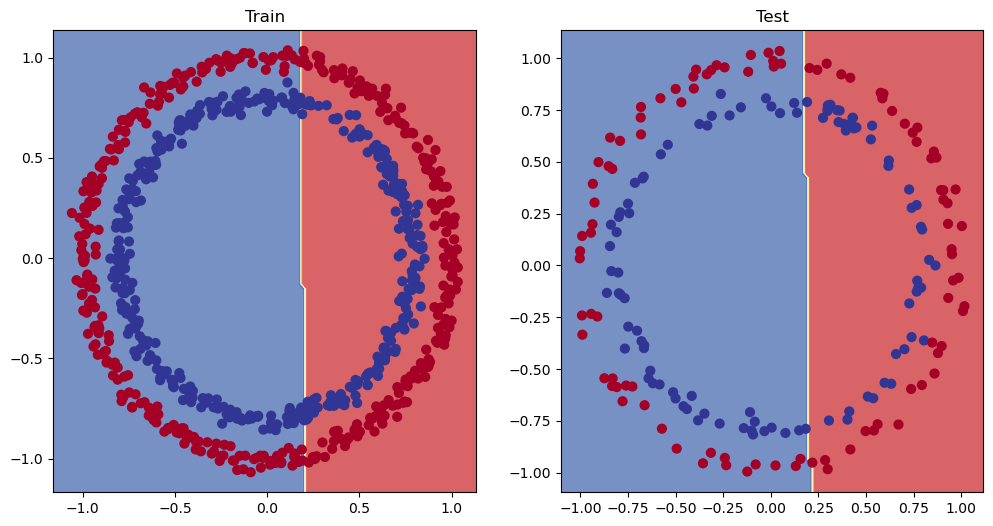

In [27]:

from helper_functions import plot_decision_boundary, plot_predictions
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_2,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_2,X_test,y_test)



In [28]:
# One way to troubleshoot a larger problem is to troubleshoot a smaller problem
# make data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01
X_reg = torch.arange(start,end,step).unsqueeze(dim=1)
y_reg = weight*X_reg +bias
print(len(X_reg))
X_reg[:5], y_reg[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [ ]:
# split
from sklearn.model_selection import train_test_split
X_trainR, X_testR, y_trainR, y_testR = train_test_split(X_reg,y_reg,test_size=0.2, random_state=42)

len(X_trainR), len(X_testR), len(y_trainR),len(y_testR)


(80, 20, 80, 20)

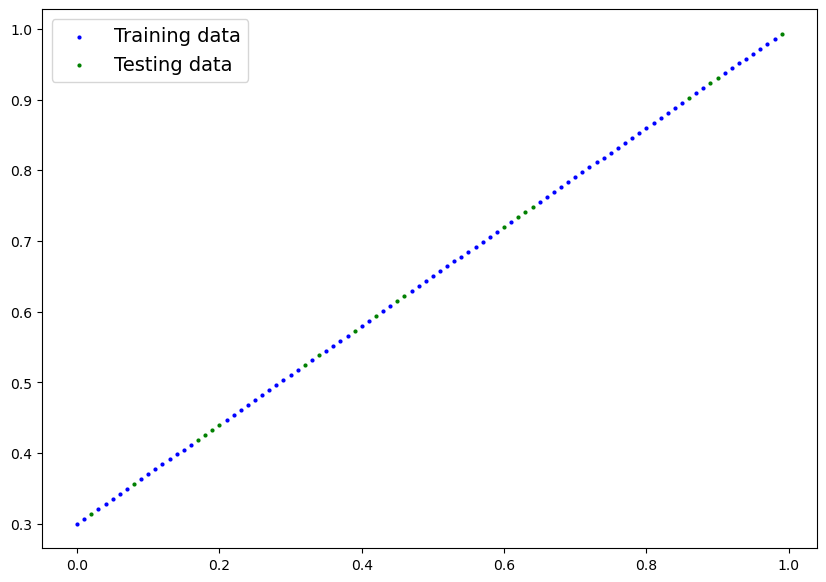

In [44]:
plot_predictions(train_data=X_trainR,
                 train_labels = y_trainR,
                 test_data=X_testR,
                 test_labels=y_testR
                 )

In [45]:

model_3 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
    
).to(device)
model_3

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [46]:
loss_fn = nn.L1Loss()
optimiser = torch.optim.SGD(params=model_3.parameters(),
                            lr =0.1)


In [47]:
torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
    y_pred = model_3(X_trainR)
    loss = loss_fn(y_pred,y_trainR)
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    model_3.eval()
    with torch.inference_mode():
        test_pred= model_3(X_testR)
        test_loss = loss_fn(test_pred, y_testR)
        test_acc = accuracy_fn(y_true=y_testR, y_pred = test_pred)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Acc: {acc:.2f}%, Test loss: {test_loss:.5f}, Test_acc: {test_acc:.2f}%')


    
    

Epoch: 0, Acc: 50.88%, Test loss: 0.40196, Test_acc: 0.00%
Epoch: 10, Acc: 50.88%, Test loss: 0.13623, Test_acc: 0.00%
Epoch: 20, Acc: 50.88%, Test loss: 0.08159, Test_acc: 0.00%
Epoch: 30, Acc: 50.88%, Test loss: 0.07528, Test_acc: 0.00%
Epoch: 40, Acc: 50.88%, Test loss: 0.07033, Test_acc: 0.00%
Epoch: 50, Acc: 50.88%, Test loss: 0.06552, Test_acc: 0.00%
Epoch: 60, Acc: 50.88%, Test loss: 0.07228, Test_acc: 0.00%
Epoch: 70, Acc: 50.88%, Test loss: 0.07717, Test_acc: 0.00%
Epoch: 80, Acc: 50.88%, Test loss: 0.06872, Test_acc: 0.00%
Epoch: 90, Acc: 50.88%, Test loss: 0.09349, Test_acc: 0.00%
Epoch: 100, Acc: 50.88%, Test loss: 0.07651, Test_acc: 0.00%
Epoch: 110, Acc: 50.88%, Test loss: 0.06512, Test_acc: 0.00%
Epoch: 120, Acc: 50.88%, Test loss: 0.07749, Test_acc: 0.00%
Epoch: 130, Acc: 50.88%, Test loss: 0.06510, Test_acc: 0.00%
Epoch: 140, Acc: 50.88%, Test loss: 0.05408, Test_acc: 0.00%
Epoch: 150, Acc: 50.88%, Test loss: 0.06974, Test_acc: 0.00%
Epoch: 160, Acc: 50.88%, Test loss:

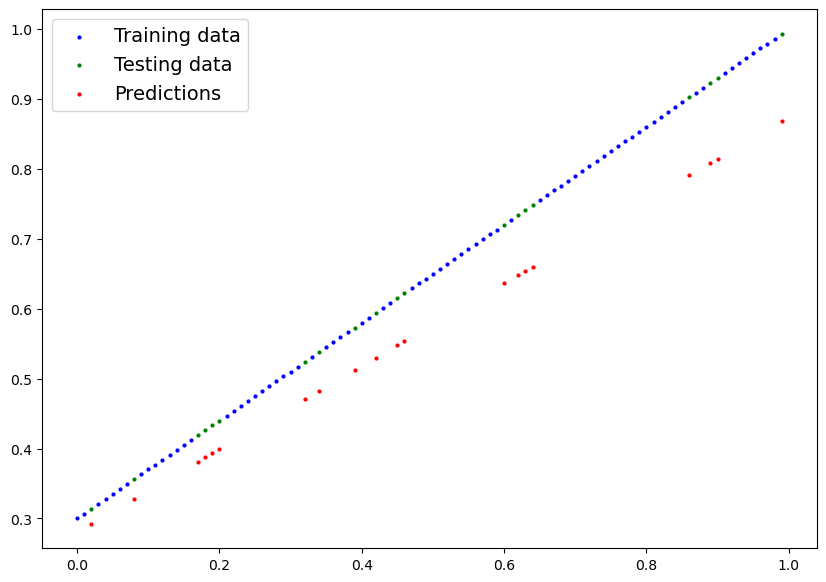

In [48]:
model_3.eval()

with torch.inference_mode():
    y_preds = model_3(X_testR)

plot_predictions(train_data=X_trainR,
                 train_labels = y_trainR,
                 test_data=X_testR,
                 test_labels=y_testR,
                 predictions=y_preds
                 )

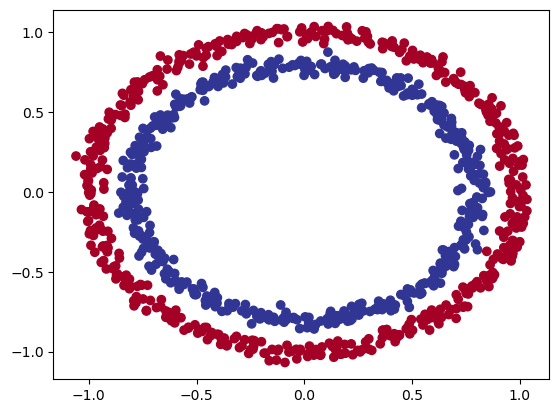

In [61]:
# To get the model to work on the vircle data, has to use non-linear functions 
# recreating circle
import matplotlib.pyplot as plt
n_samples = 1000
X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)


plt.scatter(X[:, 0],X[:, 1],c = y, cmap=plt.cm.RdYlBu);

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
X_train[:5], y_test[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 1., 0., 1.]))

In [76]:
# building non linear model
class CircleModelNL(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # non-linear activation function

    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_4 = CircleModelNL()
model_4

CircleModelNL(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [77]:
loss_fn = nn.BCEWithLogitsLoss()

optimiser = torch.optim.SGD(params=model_4.parameters(),lr = 0.1)

In [78]:
torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
    model_4.train()
    y_logits = model_4(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    acc = accuracy_fn(y_true=y_train,y_pred=y_pred )

    loss = loss_fn(y_logits, y_train)
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        #print(test_logits.size(), X_test.size())
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred = test_pred)
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Acc: {acc:.2f}%, Test loss: {test_loss:.5f}, Test_acc: {test_acc:.2f}%')


Epoch: 0, Acc: 50.00%, Test loss: 0.69319, Test_acc: 50.00%
Epoch: 10, Acc: 50.50%, Test loss: 0.69260, Test_acc: 50.00%
Epoch: 20, Acc: 59.13%, Test loss: 0.69231, Test_acc: 56.50%
Epoch: 30, Acc: 70.25%, Test loss: 0.69212, Test_acc: 68.00%
Epoch: 40, Acc: 68.38%, Test loss: 0.69195, Test_acc: 71.00%
Epoch: 50, Acc: 58.25%, Test loss: 0.69177, Test_acc: 58.00%
Epoch: 60, Acc: 54.00%, Test loss: 0.69161, Test_acc: 54.50%
Epoch: 70, Acc: 53.12%, Test loss: 0.69146, Test_acc: 53.00%
Epoch: 80, Acc: 52.62%, Test loss: 0.69132, Test_acc: 53.00%
Epoch: 90, Acc: 52.75%, Test loss: 0.69117, Test_acc: 53.00%
Epoch: 100, Acc: 52.88%, Test loss: 0.69102, Test_acc: 52.50%
Epoch: 110, Acc: 52.88%, Test loss: 0.69088, Test_acc: 53.50%
Epoch: 120, Acc: 53.12%, Test loss: 0.69074, Test_acc: 54.00%
Epoch: 130, Acc: 53.00%, Test loss: 0.69058, Test_acc: 54.50%
Epoch: 140, Acc: 53.00%, Test loss: 0.69043, Test_acc: 54.50%
Epoch: 150, Acc: 52.88%, Test loss: 0.69027, Test_acc: 55.00%
Epoch: 160, Acc: 53

In [79]:
model_4.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_4(X_test))).squeeze()

y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

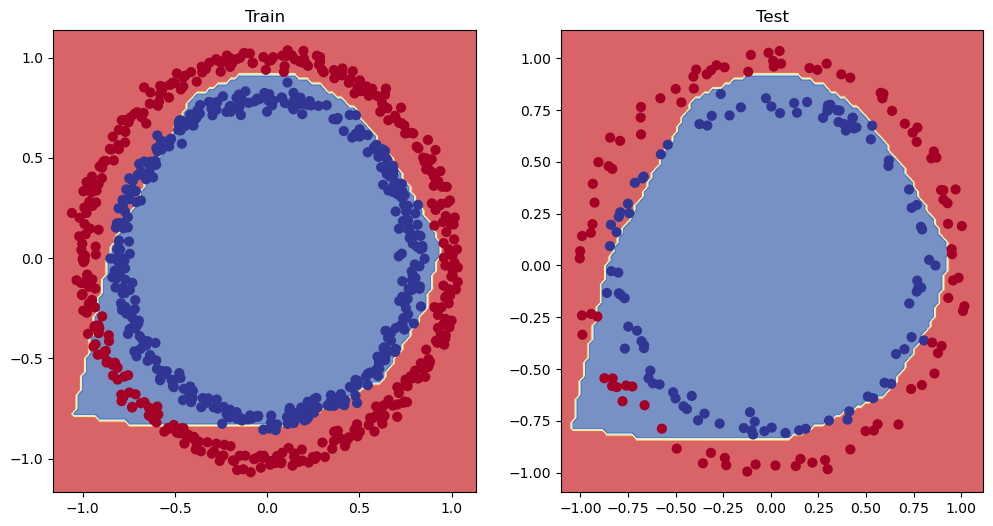

In [80]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_4,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_4,X_test,y_test)


In [81]:
model_4.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.6760,  0.8035],
                      [-0.1997,  0.7568],
                      [-0.1549,  0.1427],
                      [-0.9637,  0.2292],
                      [ 0.5717, -1.3426],
                      [ 0.6689,  0.1840],
                      [ 0.7970,  0.2595],
                      [ 0.3410, -0.0998],
                      [ 0.6555,  0.3186],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3761, -0.2008, -0.2872,  0.2803, -0.4513, -0.3364, -0.3300, -0.4252,
                      -0.1989, -0.6984])),
             ('layer_2.weight',
              tensor([[ 1.3081e-01, -3.7347e-01,  2.4414e-01, -4.3348e-02, -2.7270e-01,
                        1.0512e-01, -4.7109e-02,  2.5550e-01, -4.9248e-02, -9.9730e-02],
                      [ 7.9469e-01,  3.8277e-01,  1.3309e-01,  7.5399e-01,  9.7241e-01,
                        2.6996e-01,  6.2185e-01,  5.6581e-02,  5.3486e-01, -1.927

In [82]:
A = torch.arange(-10,10,1, dtype = torch.float32)
A.dtype

torch.float32

In [83]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

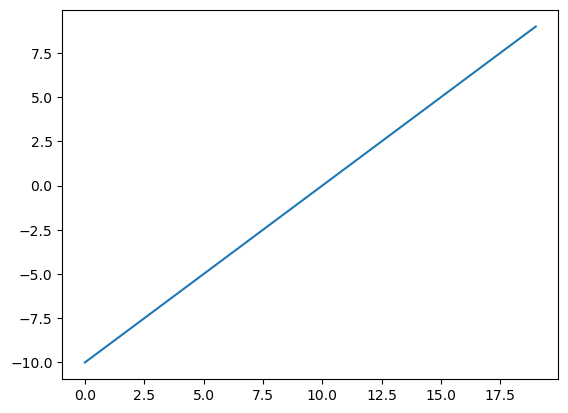

In [84]:
plt.plot(A)

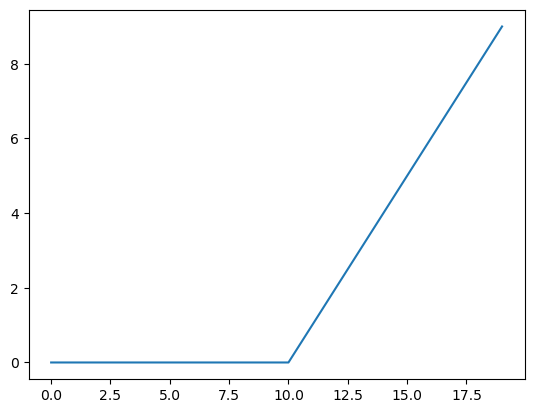

In [85]:
plt.plot(torch.relu(A))

In [ ]:

def relu(x):
    return torch.maximum(torch.tensor(0), x)

relu(A)


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

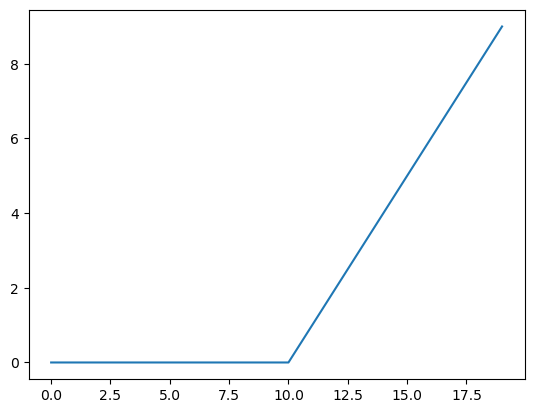

In [89]:
# plot custom relu
plt.plot(relu(A))

In [90]:
# do same for sigmoid 

def sig(x):
    return 1/(1+torch.exp(-x))

In [91]:
sig(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

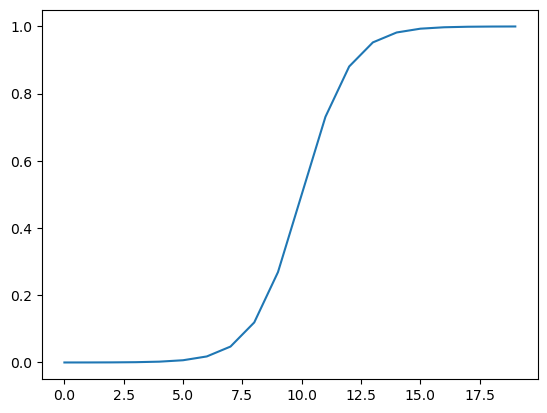

In [94]:
plt.plot(torch.sigmoid(A))

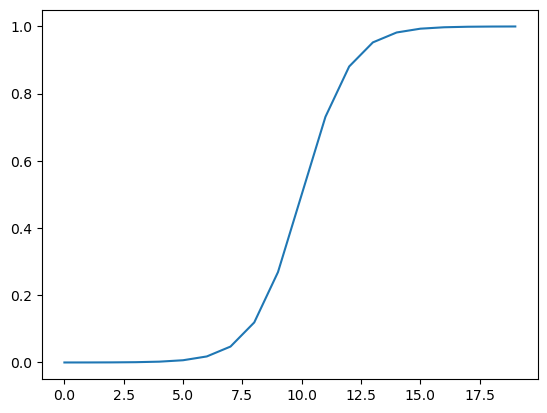

In [95]:
plt.plot(sig(A))


In [117]:
# Creating toy multiclass dataset

from sklearn.datasets import make_blobs


# set hparameters for data creation

NUM_CLASSES=  4
NUM_FEATS = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples = 1000,
                            centers=NUM_CLASSES,
                            cluster_std =1.5,
                            random_state=RANDOM_SEED)

#turn data into tensors

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
X_blob_train, X_blob_test, y_blob_train,y_blob_test = train_test_split(X_blob,
                                                                       y_blob,
                                                                       test_size = 0.3,
                                                                       random_state=RANDOM_SEED)

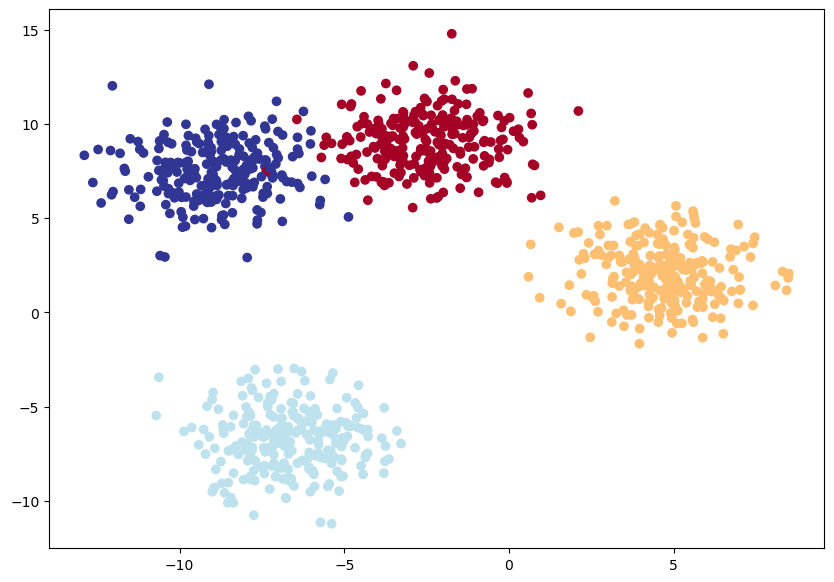

In [118]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1],c = y_blob, cmap = plt.cm.RdYlBu)

In [119]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        '''Initialises multiclass classification model
        Args:
        input_features(int): Number of input features to the model
        output_features(int): Number of output features (number of output classes)
        hidden_units (int): Number of hidden units between layers , default =8'''
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_features)    
        )
    def forward(self,x):
        return self.linear_layer_stack(x)
model_5 = BlobModel(input_features=2,output_features=4)
model_5

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [120]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(params = model_5.parameters(),lr=0.1)



In [121]:
# Getting prediction probs for MC model
model_5(X_blob_test)

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        ...,
        [-0.7639, -0.6799, -1.4862, -1.0470],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.6546, -0.6274, -1.3239, -0.9473]], grad_fn=<AddmmBackward0>)

In [122]:
model_5.eval()
with torch.inference_mode():
    y_logits = model_5(X_blob_test)

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [123]:
y_pred_probs = torch.softmax(y_logits,dim=1) # makes prediction probabilities
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])


In [124]:
y_preds  = torch.argmax(y_pred_probs,dim=1)
y_preds, y_blob_test
y_blob_train.dtype

torch.int64

In [125]:
torch.manual_seed(42)
epochs = 100

for epoch in range(epochs):

    model_5.train()
    y_logits = model_5(X_blob_train)
    y_pred=torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits,y_blob_train)
    acc = accuracy_fn(y_true= y_blob_train,
                      y_pred=y_pred)
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    model_5.eval()
    with torch.inference_mode():
        test_logits = model_5(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_preds)
        
    if epoch % 10 == 0:
        print(f'Epoch: {epoch}, Acc: {acc:.2f}%, Test loss: {test_loss:.5f}, Test_acc: {test_acc:.2f}%')

        
        





Epoch: 0, Acc: 38.71%, Test loss: 1.06409, Test_acc: 54.33%
Epoch: 10, Acc: 96.71%, Test loss: 0.64015, Test_acc: 96.33%
Epoch: 20, Acc: 98.29%, Test loss: 0.41821, Test_acc: 99.33%
Epoch: 30, Acc: 99.14%, Test loss: 0.23742, Test_acc: 99.67%
Epoch: 40, Acc: 99.29%, Test loss: 0.09796, Test_acc: 99.33%
Epoch: 50, Acc: 99.29%, Test loss: 0.05587, Test_acc: 99.33%
Epoch: 60, Acc: 99.29%, Test loss: 0.04086, Test_acc: 99.33%
Epoch: 70, Acc: 99.29%, Test loss: 0.03307, Test_acc: 99.33%
Epoch: 80, Acc: 99.14%, Test loss: 0.02845, Test_acc: 99.33%
Epoch: 90, Acc: 99.29%, Test loss: 0.02539, Test_acc: 99.33%


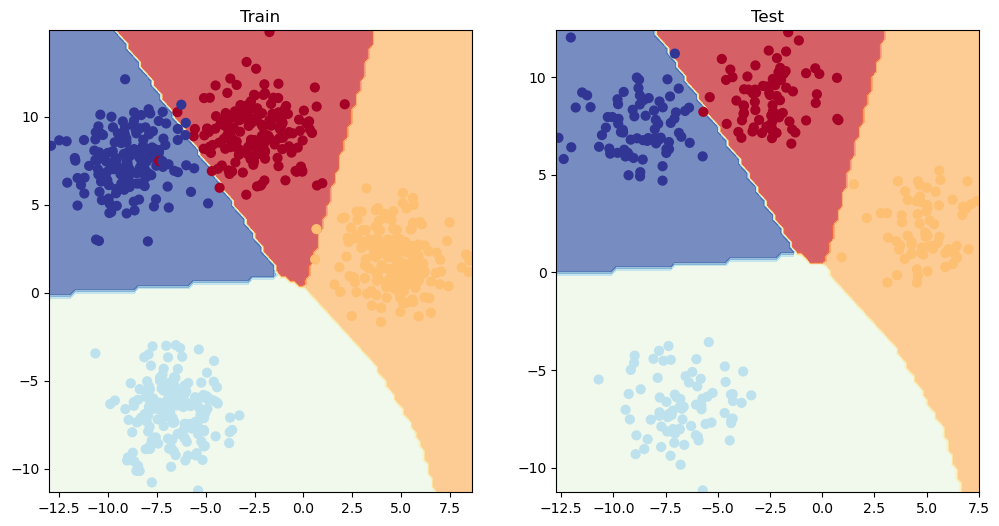

In [126]:
model_5.eval()
with torch.inference_mode():
    y_logits= model_5(X_blob_test)



plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_5,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_5,X_blob_test,y_blob_test)




### Some classification metrics 

1. accuracy
2. precision
3. recall
4. F1 Score
5. Confusion matrix 
6. Classification report 